# GLayout Current Mirror Tutorial
```
OpenFASOC Team, June 2025
SPDX-License-Identifier: Apache-2.0
```


## Introduction
Welcome!
This notebook serves as an introduction to the GDSFactory-based layout automation tool **GLayout** and an example producing a VIA to explain grules and glayers, as a part of [OpenFASoC](https://github.com/idea-fasoc/OpenFASOC).  

In [4]:
from glayout import sky130, gf180
from glayout.primitives.via_gen import via_stack, via_array
from glayout.primitives.fet import nmos, pmos, multiplier
from glayout.primitives.guardring import tapring
from glayout.util.port_utils import PortTree, rename_ports_by_orientation
from glayout.util.comp_utils import move, movex, movey, align_comp_to_port, evaluate_bbox, prec_center
from glayout.routing.straight_route import straight_route
from glayout.routing.c_route import c_route
from gdsfactory import Component
import gdstk
import svgutils.transform as sg
import IPython.display
from IPython.display import clear_output
import ipywidgets as widgets

# Redirect all outputs here
hide = widgets.Output()

def display_gds(gds_file, scale = 3):
  # Generate an SVG image
  top_level_cell = gdstk.read_gds(gds_file).top_level()[0]
  top_level_cell.write_svg('out.svg')
  # Scale the image for displaying
  fig = sg.fromfile('out.svg')
  fig.set_size((str(float(fig.width) * scale), str(float(fig.height) * scale)))
  fig.save('out.svg')

  # Display the image
  IPython.display.display(IPython.display.SVG('out.svg'))

def display_component(component, scale = 3):
  # Save to a GDS file
  with hide:
    component.write_gds("out.gds")
  display_gds('out.gds', scale)

# Current Mirror Layout Design using GLayout API
 
## Overview
This document provides a detailed tutorial on using the GLayout API to design and generate a layout for a PMOS current mirror circuit. It outlines the steps to initialize the layout components, place the devices, make necessary adjustments, route the connections, and generate the final layout for visualization.

## Prerequisites

Ensure that you have the following installed:
- Python environment with access to GLayout API.
- GDSFactory package for handling generic layout components.
- A PDK (Process Design Kit) appropriate for the technology node you're working on (e.g., `gf180` in this example).

## Step-by-Step Guide

### Step 1: Setting up the Environment

**1.1 Import Required Modules**
Begin by importing the necessary classes and functions from the GLayout and GDSFactory packages:


In [5]:
from glayout.primitives.guardring import tapring
from glayout.primitives.fet import pmos
from glayout.util.comp_utils import evaluate_bbox, prec_center
from glayout.routing.straight_route import straight_route
from glayout.routing.c_route import c_route
from gdsfactory import Component


### Step 2: Define the Current Mirror Function

**2.1 Initialize the Current Mirror Component**
Within your Python script, start by defining the `currentMirror` function that takes in a `MappedPDK` object:
```python
def currentMirror(pdk: MappedPDK):
    currMirrComp = Component()
```

**2.2 Create the Transistor Instances**
Use the PDK to instantiate two PMOS transistors, a reference and a mirror, with specified modifications:
```python
    pfet_ref = pmos(with_substrate_tap=False, with_dummy=(False, True))
    pfet_mir = pmos(with_substrate_tap=False, with_dummy=(True, False))
```

**2.3 Add Transistors to the Component**
Insert the transistors into the current mirror component and position them:
```python
    cref_ref = currMirrComp << pfet_ref
    cmir_ref = currMirrComp << pfet_mir
    cref_ref.movex(evaluate_bbox(pfet_mir)[0] + max_metal_separation(pdk))
```

**2.4 Add and Position the Tap Ring**
Incorporate a tap ring and ensure it encloses the transistors with additional padding to satisfy design rules:
```python
    tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(currMirrComp.flatten(), padding=pdk.get_grule("nwell", "active_diff")["min_enclosure"]))
    shift_amount = -prec_center(currMirrComp.flatten())[0]
    tring_ref = currMirrComp << tap_ring
    tring_ref.movex(destination=shift_amount)
```

**2.5 Route the Connections**
Create routes between the ports:
```python
    currMirrComp << straight_route(pdk, cref_ref.ports["multiplier_0_source_E"], cmir_ref.ports["multiplier_0_source_E"])
    currMirrComp << straight_route(pdk, cref_ref.ports["multiplier_0_gate_E"], cmir_ref.ports["multiplier_0_gate_E"])
    currMirrComp << c_route(pdk, cref_ref.ports["multiplier_0_gate_E"], cref_ref.ports["multiplier_0_drain_E"])

    return currMirrComp
```

### Step 3: Visualizing the Layout

**3.1 Generate and View the Layout**
Finally, visualize the generated layout by calling the `currentMirror` function and using the `.show()` method:
```python
# To visualize the layout
currentMirror(gf180).show()
```

Create the final design cell with the following code block:

/tmp/ipykernel_912/2400741529.py:18: UserWarning: Unnamed cells, 4 in 'Unnamed_9d890891'
  currentMirror(gf180).write_gds("cmirror_example.gds")
2025-06-26 18:24:29.638 | INFO     | gdsfactory.component:_write_library:1851 - Wrote to 'cmirror_example.gds'


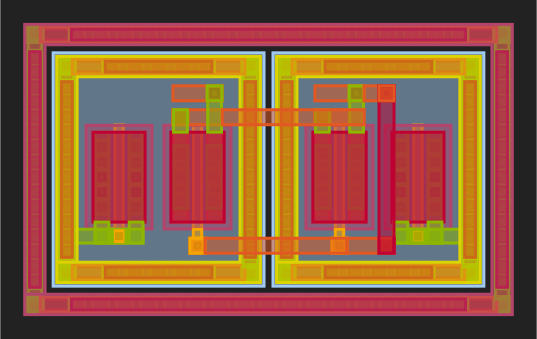

In [6]:
def currentMirror(pdk):
  currMirrComp = Component()
  pfet_ref = pmos(pdk, with_substrate_tap=False, with_dummy=(False, True))
  pfet_mir = pmos(pdk, with_substrate_tap=False, with_dummy=(True, False))
  cref_ref = currMirrComp << pfet_ref
  cmir_ref = currMirrComp << pfet_mir
  pdk.util_max_metal_seperation()
  cref_ref.movex(evaluate_bbox(pfet_mir)[0] + pdk.util_max_metal_seperation())
  tap_ring = tapring(pdk, enclosed_rectangle=evaluate_bbox(currMirrComp.flatten(), padding=pdk.get_grule("nwell", "active_diff")["min_enclosure"]))
  shift_amount = -prec_center(currMirrComp.flatten())[0]
  tring_ref = currMirrComp << tap_ring
  tring_ref.movex(destination=shift_amount)
  currMirrComp << straight_route(pdk, cref_ref.ports["multiplier_0_source_E"], cmir_ref.ports["multiplier_0_source_E"])
  currMirrComp << straight_route(pdk, cref_ref.ports["multiplier_0_gate_E"], cmir_ref.ports["multiplier_0_gate_E"])
  currMirrComp << c_route(pdk, cref_ref.ports["multiplier_0_gate_E"], cref_ref.ports["multiplier_0_drain_E"])
  return currMirrComp

currentMirror(gf180).write_gds("cmirror_example.gds")
display_gds("cmirror_example.gds")

## Conclusion

Following these steps results in a PMOS current mirror layout being composed and visualized. The tap ring encloses the transistors and the routing utilities are used to create the required connections respecting the design rules specified by the PDK.

Each function call and module used here directly corresponds to a specific structure or operation within the context of the PDK and the layout process. This example provides a foundation upon which more complex circuits can be designed using the powerful features of the GLayout API.